In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import keras.backend as K
from keras.layers import Input, Dense, Merge
from keras.models import Model
from keras.optimizers import Adam

Using Theano backend.


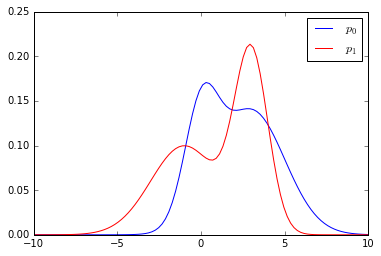

In [2]:
from carl.distributions import Mixture, Normal
p0 = Mixture(components=[Normal(0, 1), Normal(3, 2)], weights=[0.3, 0.7])
p1 = Mixture(components=[Normal(-1, 2), Normal(3, 1)], weights=[0.5, 0.5])

x = np.linspace(-10, 10, 100).reshape(-1, 1)
plt.plot(x, p0.pdf(x), label="$p_0$", color="blue")
plt.plot(x, p1.pdf(x), label="$p_1$", color="red")
plt.legend()
plt.show()

In [3]:
n_samples = 50000

X0 = np.zeros(n_samples).reshape(-1,1)
X1 = np.ones(n_samples).reshape(-1,1)
y0 = p0.rvs(n_samples)
y1 = p1.rvs(n_samples)
X = np.vstack([X0,X1])
y = np.vstack([y0,y1]).ravel()

In [4]:
n_components = 2

inputs = Input(shape=(1,))
h = Dense(4, activation="relu")(inputs)
h = Dense(4, activation="relu")(h)
h = Dense(4, activation="relu")(h)

mu = Dense(n_components, activation="linear")(h)
sigma = Dense(n_components, activation=K.exp)(h)
pi = Dense(n_components, activation="softmax")(h)

MDN = Model(input=[inputs], output=[Merge(mode="concat")([mu, sigma, pi])])

In [5]:
def make_loss(n_components):
    def loss(y_true, y_pred):
        y_true = y_true.ravel()
        
        mu = y_pred[:, :n_components]
        sigma = y_pred[:, n_components:2*n_components]
        pi = y_pred[:, 2*n_components:]
        
        pdf = pi[:, 0] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, 0] *
                          K.exp(-(y_true - mu[:, 0]) ** 2 / (2. * sigma[:, 0] ** 2)))
        
        for c in range(1, n_components):
            pdf += pi[:, c] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, c] *
                               K.exp(-(y_true - mu[:, c]) ** 2 / (2. * sigma[:, c] ** 2)))
        
        nll = -K.log(pdf)
        
        return nll.mean()
    
    return loss

In [6]:
MDN.compile(loss=make_loss(n_components), optimizer=Adam())

In [7]:
MDN.fit(X, y)

Epoch 1/10
100000/100000 [==============================] - 2s - loss: 2.3858     
Epoch 2/10
100000/100000 [==============================] - 2s - loss: 2.2354     
Epoch 3/10
100000/100000 [==============================] - 2s - loss: 2.2172     
Epoch 4/10
100000/100000 [==============================] - 2s - loss: 2.2160     
Epoch 5/10
100000/100000 [==============================] - 2s - loss: 2.2158     
Epoch 6/10
100000/100000 [==============================] - 2s - loss: 2.2159     
Epoch 7/10
100000/100000 [==============================] - 2s - loss: 2.2156     
Epoch 8/10
100000/100000 [==============================] - 2s - loss: 2.2157     
Epoch 9/10
100000/100000 [==============================] - 2s - loss: 2.2156     
Epoch 10/10
100000/100000 [==============================] - 2s - loss: 2.2156     


[ 3.07774854 -0.00803924  1.9548074   1.03438079  0.69855869  0.30144131]
[ 3.03927994 -1.1068505   0.99770272  2.00928044  0.51911652  0.48088351]


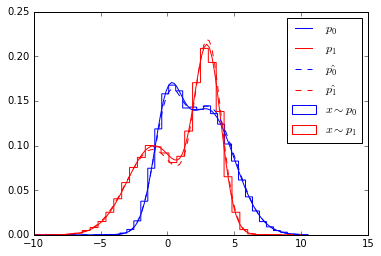

In [8]:
plt.plot(x, p0.pdf(x), label="$p_0$", color="blue")
plt.plot(x, p1.pdf(x), label="$p_1$", color="red")

params = MDN.predict(np.array([[0.]])).ravel()
print(params)
p = Mixture(components=[Normal(params[0], params[2]), Normal(params[1], params[3])], weights=[params[4], params[5]])
x = np.linspace(-10, 10, 100).reshape(-1, 1)
plt.plot(x, p.pdf(x), "--", c="blue", label=r"$\hat{p_0}$")
plt.hist(y[X.ravel()==0], histtype="step", bins=30, normed=1, color="blue", label=r"$x \sim p_0$")

params = MDN.predict(np.array([[1.]])).ravel()
print(params)
p = Mixture(components=[Normal(params[0], params[2]), Normal(params[1], params[3])], weights=[params[4], params[5]])
x = np.linspace(-10, 10, 100).reshape(-1, 1)
plt.plot(x, p.pdf(x), "--", c="red", label=r"$\hat{p_1}$")
plt.hist(y[X.ravel()==1], histtype="step", bins=30, normed=1, color="red", label=r"$x \sim p_1$")

plt.legend()
plt.show()